<a href="https://colab.research.google.com/github/stanislavkrk/clustering_and_classification/blob/main/main_pipeline_clustering(ws04).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from datetime import datetime
import pandas as pd

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, HDBSCAN
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from umap import UMAP

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

import numpy as np
import math




# Project Overview
---

### Customer Segmentation via Clustering Techniques: A Marketing-Oriented Analysis

## Objective:

The primary aim of this project is to explore unsupervised learning techniques for customer segmentation based on purchasing behavior and demographic data. By applying several clustering algorithms and dimensionality reduction techniques, we aim to uncover meaningful customer groups that can be used for targeted marketing strategies.

### Motivation

In modern marketing, personalization is key. Instead of applying the same campaign to all clients, companies can group customers into meaningful segments and address them with tailored offers. This allows for:

- Increasing conversion rates,
- Reducing marketing costs,
- Improving customer satisfaction and retention.

## Research Goals

Understand and prepare the dataset by exploring, cleaning, and preprocessing variables relevant to customer profiling.
Apply and compare different clustering algorithms, including:

- K-Means
- Hierarchical Clustering
- DBSCAN
- Gaussian Mixture Model (GMM)

In addition:

- Evaluate the performance of clustering using metrics like silhouette score and visual analysis.
- Reduce dimensionality with Principal Component Analysis (PCA) for better visualization and cluster separation.
- Interpret each cluster: identify key behavioral or demographic traits within each group.
- Translate findings into actionable insights that can support real-world marketing decisions.

### Tools and Techniques

- Data Preprocessing: Normalization, Standardization
- Distance Metrics: Euclidean, Manhattan
- Clustering Methods: K-Means, Hierarchical, DBSCAN, GMM
- PCA for feature reduction and visualization
- Evaluation: Silhouette Score, Elbow Method, Cluster Profiles

---

# Data Preparation

In this section, we prepare the dataset for clustering by cleaning, transforming, and engineering relevant features. The steps are as follows:

### 1. Handling Missing Values
- We inspect the dataset for missing entries.
- Rows with missing values in the `Income` column will be removed, as this is a key numerical feature and only a small number of rows (24 out of 2240) are affected.

### 2. Date Conversion
- The `Dt_Customer` column represents the date when the customer joined.
- We convert it to datetime format and calculate a new feature indicating the number of days the customer has been in the system (recency of registration).

### 3. Feature Engineering
- `Age` = 2025 − `Year_Birth` — a derived feature representing the current age of the customer.
- `Total_Children` = `Kidhome` + `Teenhome` — the total number of children living at home.
- `Total_Spent` = sum of all product category expenditures: `MntWines`, `MntFruits`, `MntMeatProducts`, `MntFishProducts`, `MntSweetProducts`, `MntGoldProds`.
- `Total_Accepted_Campaigns` = sum of `AcceptedCmp1` to `AcceptedCmp5` — a measure of marketing responsiveness.

### 4. Categorical Encoding
- The `Education` and `Marital_Status` columns contain categorical values.
- We apply label encoding to convert them into numerical form.

### 5. Removing Irrelevant Columns
- `ID` is a unique identifier with no analytical value for clustering.
- `Z_CostContact` and `Z_Revenue` are constant values and do not contribute any useful information. They will be removed.


In [ ]:
# Data loading
data = "https://drive.google.com/uc?export=download&id=1rzZwbGwdtrR5GmTsP3rNHj6sgzzM8Z_r"
df = pd.read_csv(data, sep=';')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [ ]:
# Copy original dataset
df_clean = df.copy()

# 1. Delete rows with missing values
df_clean = df_clean.dropna(subset=['Income'])

# 2. Convert Dt_Customer to date + create a “days_since_registration” trait.
df_clean['Dt_Customer'] = pd.to_datetime(df_clean['Dt_Customer'], format='%Y-%m-%d')
df_clean['Days_Since_Registration'] = (datetime(2025, 1, 1) - df_clean['Dt_Customer']).dt.days

# 3. Features engineering
df_clean['Age'] = 2025 - df_clean['Year_Birth']
df_clean['Total_Children'] = df_clean['Kidhome'] + df_clean['Teenhome']

spending_cols = [
    'MntWines', 'MntFruits', 'MntMeatProducts',
    'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'
]
df_clean['Total_Spent'] = df_clean[spending_cols].sum(axis=1)

campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
df_clean['Total_Accepted_Campaigns'] = df_clean[campaign_cols].sum(axis=1)

# 4. Coding category variables
# 4.1 Education
le_edu = LabelEncoder()
df_clean['Education'] = le_edu.fit_transform(df_clean['Education'])

# Make a dictionary
education_mapping = dict(zip(le_edu.classes_, le_edu.transform(le_edu.classes_)))
print(education_mapping)

# 4.2 Marital status
other = ['Alone', 'Absurd', 'YOLO']
df_clean['Marital_Status'] = df_clean['Marital_Status'].replace(other, 'Other')

marital_counts = df_clean['Marital_Status'].value_counts()
print(marital_counts)

le_marital = LabelEncoder()
df_clean['Marital_Status'] = le_marital.fit_transform(df_clean['Marital_Status'])

# Make a dictionary
marital_mapping_cleaned = dict(zip(le_marital.classes_, le_marital.transform(le_marital.classes_)))
print(marital_mapping_cleaned)

# 5. Drop unuseful features
df_clean = df_clean.drop(columns=['ID', 'Z_CostContact', 'Z_Revenue', 'Kidhome', 'Teenhome', 'Year_Birth'])
df_clean.shape
df_clean.head()

{'2n Cycle': np.int64(0), 'Basic': np.int64(1), 'Graduation': np.int64(2), 'Master': np.int64(3), 'PhD': np.int64(4)}
Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Other         7
Name: count, dtype: int64
{'Divorced': np.int64(0), 'Married': np.int64(1), 'Other': np.int64(2), 'Single': np.int64(3), 'Together': np.int64(4), 'Widow': np.int64(5)}


,Education,Marital_Status,Income,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Days_Since_Registration,Age,Total_Children,Total_Spent,Total_Accepted_Campaigns
0,2,3,58138.0,2012-09-04,58,635,88,546,172,88,...,0,0,0,0,1,4502,68,0,1617,0
1,2,3,46344.0,2014-03-08,38,11,1,6,2,1,...,0,0,0,0,0,3952,71,2,27,0
2,2,4,71613.0,2013-08-21,26,426,49,127,111,21,...,0,0,0,0,0,4151,60,0,776,0
3,2,4,26646.0,2014-02-10,26,11,4,20,10,3,...,0,0,0,0,0,3978,41,1,53,0
4,4,1,58293.0,2014-01-19,94,173,43,118,46,27,...,0,0,0,0,0,4000,44,1,422,0


In [ ]:
# df_clean.to_csv('testing_clean.csv', index=False, sep=';')

### Check the data types

In [ ]:
df_clean.dtypes

,0
Education,int64
Marital_Status,int64
Income,float64
Dt_Customer,datetime64[ns]
Recency,int64
MntWines,int64
MntFruits,int64
MntMeatProducts,int64
MntFishProducts,int64
MntSweetProducts,int64


### Check the main statistics

In [ ]:
df_clean.describe(include='all')

,Education,Marital_Status,Income,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Days_Since_Registration,Age,Total_Children,Total_Spent,Total_Accepted_Campaigns
count,2216.000000,2216.000000,2216.000000,2216,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,2.393953,2.236462,52247.251354,2013-07-10 11:29:27.509025280,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,...,0.073105,0.064079,0.013538,0.009477,0.150271,4192.521209,56.179603,0.947202,607.075361,0.298285
min,0.000000,0.000000,1730.000000,2012-07-30 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3839.000000,29.000000,0.000000,5.000000,0.000000
25%,2.000000,1.000000,35303.000000,2013-01-16 00:00:00,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4019.000000,48.000000,0.000000,69.000000,0.000000
50%,2.000000,3.000000,51381.500000,2013-07-08 12:00:00,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4194.500000,55.000000,1.000000,396.500000,0.000000
75%,3.000000,4.000000,68522.000000,2013-12-31 00:00:00,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4368.000000,66.000000,1.000000,1048.000000,0.000000
max,4.000000,5.000000,666666.000000,2014-06-29 00:00:00,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,4538.000000,132.000000,3.000000,2525.000000,4.000000
std,1.124141,1.518597,25173.076661,NaN,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,...,0.260367,0.244950,0.115588,0.096907,0.357417,202.434667,11.985554,0.749062,602.900476,0.679209


In [ ]:
df_clean.head()

,Education,Marital_Status,Income,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Days_Since_Registration,Age,Total_Children,Total_Spent,Total_Accepted_Campaigns
0,2,3,58138.0,2012-09-04,58,635,88,546,172,88,...,0,0,0,0,1,4502,68,0,1617,0
1,2,3,46344.0,2014-03-08,38,11,1,6,2,1,...,0,0,0,0,0,3952,71,2,27,0
2,2,4,71613.0,2013-08-21,26,426,49,127,111,21,...,0,0,0,0,0,4151,60,0,776,0
3,2,4,26646.0,2014-02-10,26,11,4,20,10,3,...,0,0,0,0,0,3978,41,1,53,0
4,4,1,58293.0,2014-01-19,94,173,43,118,46,27,...,0,0,0,0,0,4000,44,1,422,0


# Working with outliers
---

## Boxplot for detection outliers

In [ ]:
exclude = [
    'Dt_Customer',
    'Total_Accepted_Campaigns',
    'AcceptedCmp1',
    'AcceptedCmp2',
    'AcceptedCmp3',
    'AcceptedCmp4',
    'AcceptedCmp5',
    'Complain',
    'Response',
    'Education',
    'Marital_Status',
    'Age',
    'Total_Children'
]

In [ ]:
def outliers_box (df, exclude):
    numeric_cols = df.select_dtypes(include=np.number).columns
    features = [col for col in numeric_cols if col not in exclude]

    n = len(features)
    cols = 8
    rows = int(np.ceil(n / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 8))
    axes = axes.flatten()

    for i, col in enumerate(features):
        sns.boxplot(data=df, y=col, ax=axes[i], color='skyblue')
        axes[i].set_title(col)
        axes[i].set_xlabel('')
        axes[i].grid(True)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


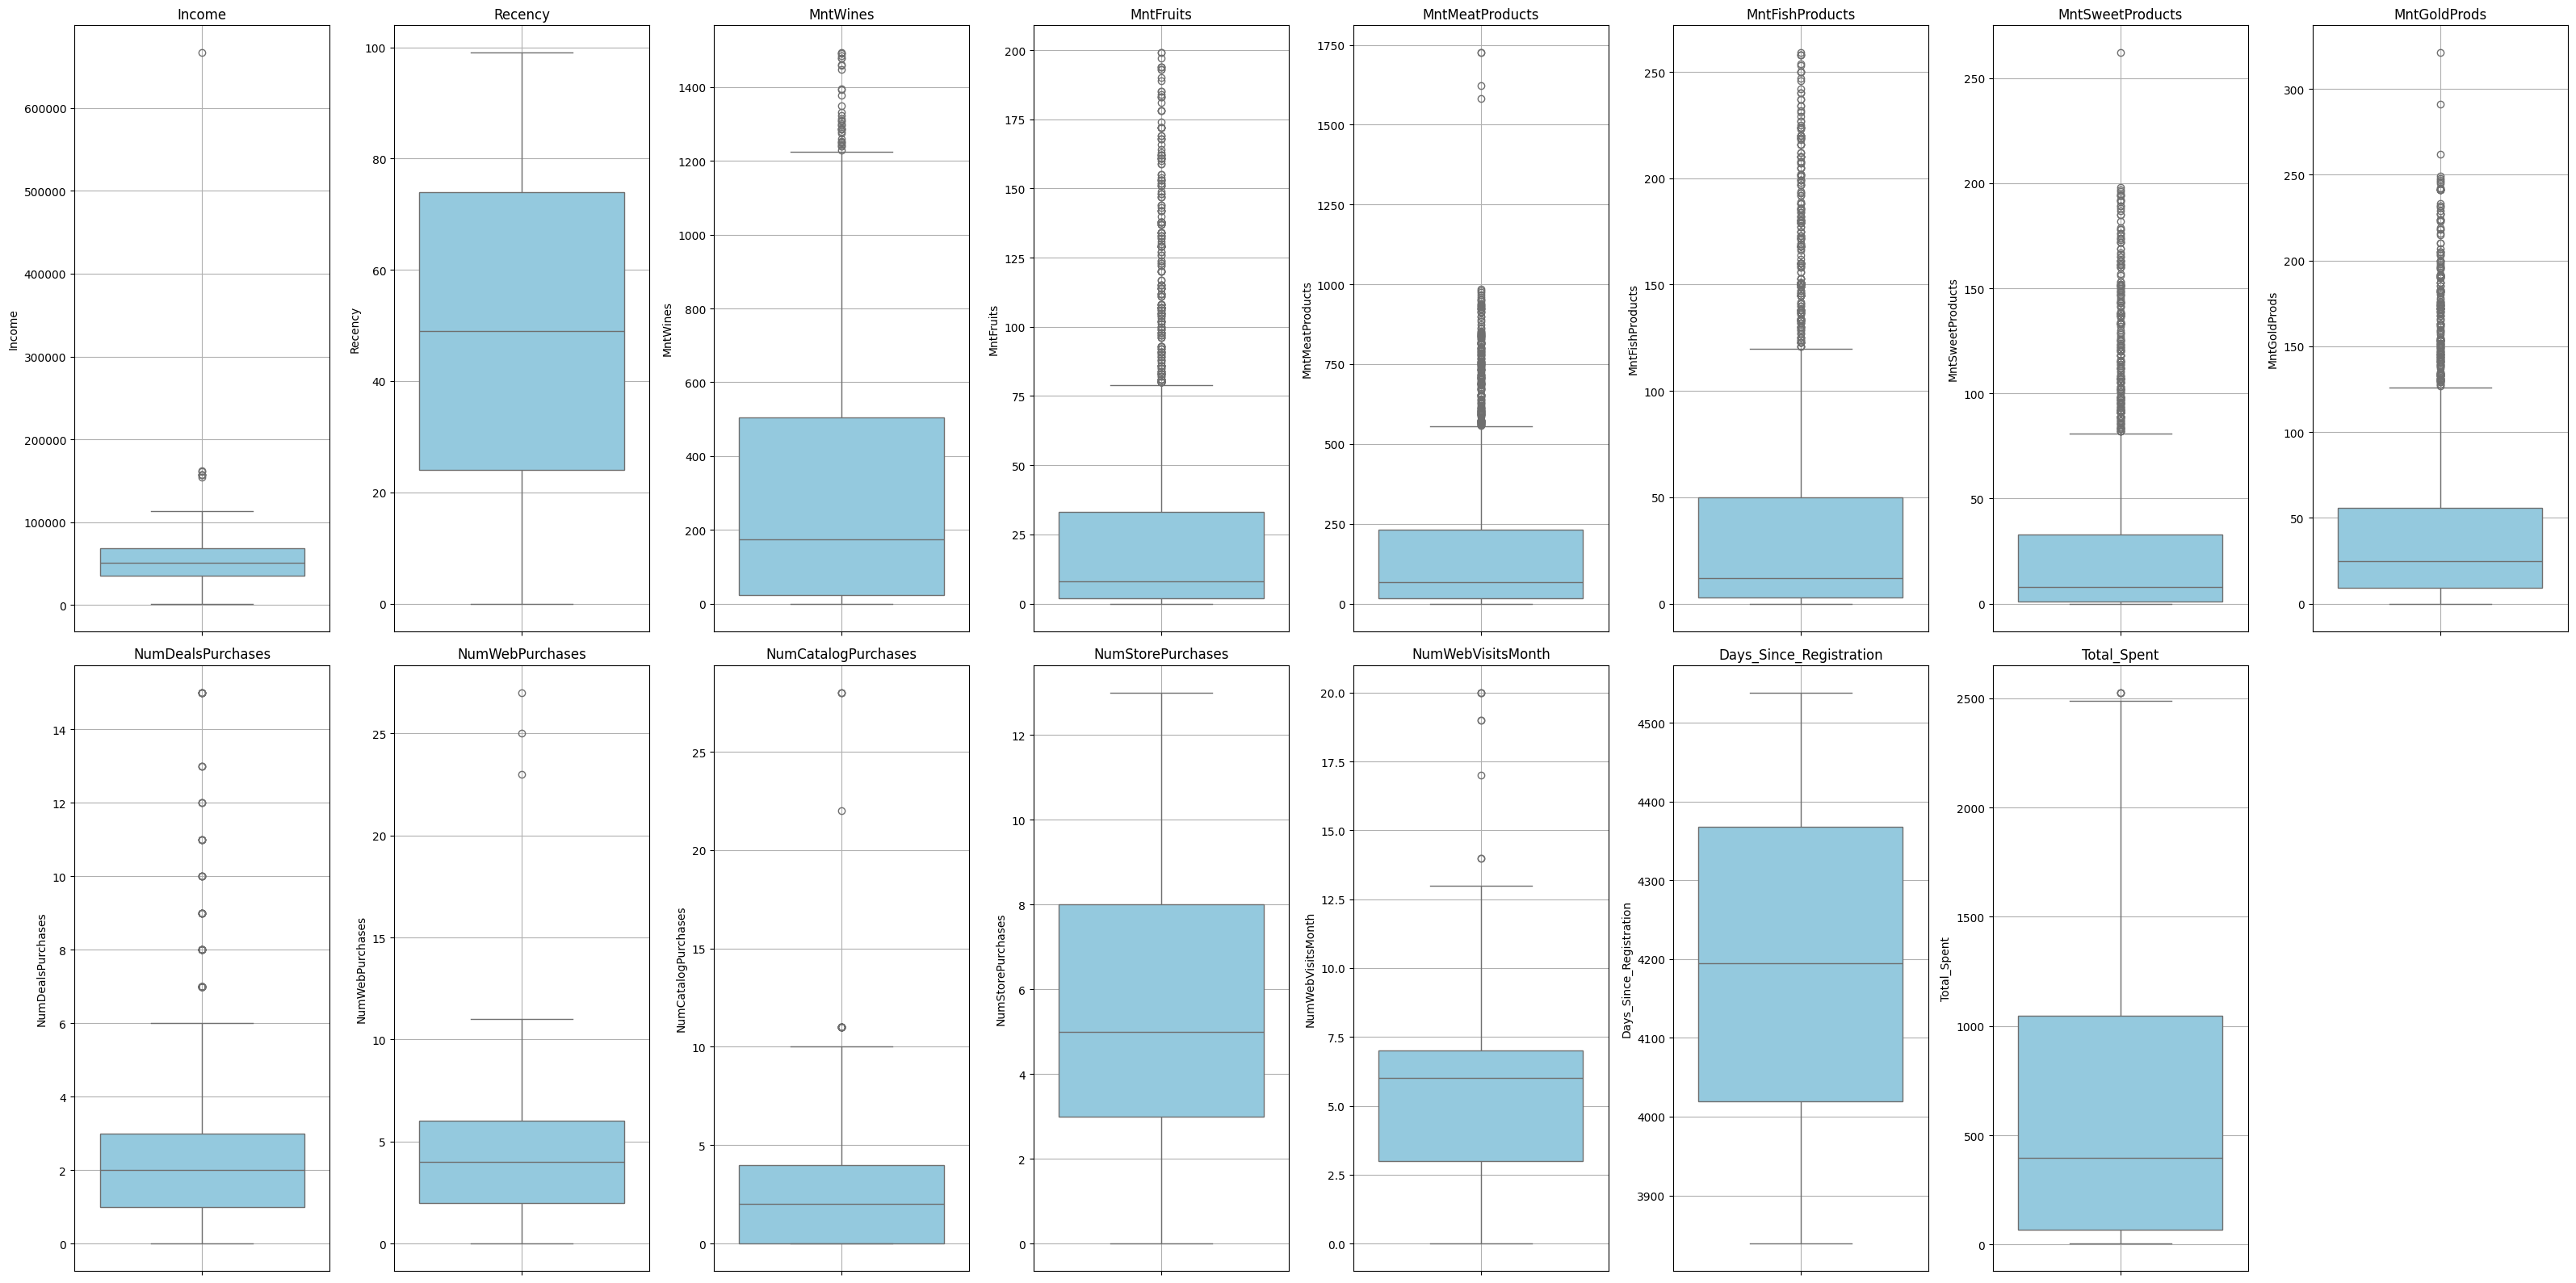

In [ ]:
outliers_box(df_clean, exclude)

### Using anomaly capper

In [ ]:
def cap_outliers(df: pd.DataFrame, cols: list, lower_quantile=0.01, upper_quantile=0.99) -> pd.DataFrame:
    '''
    Caps outliers in specified columns based on quantiles.

    :param df: pd.DataFrame – input dataframe
    :param cols: list – list of columns to cap
    :param lower_quantile: float – lower quantile threshold (default 0.01)
    :param upper_quantile: float – upper quantile threshold (default 0.99)
    :return: df: pd.DataFrame with capped values
    '''

    df_capped = df.copy()
    for col in cols:
        lower = df[col].quantile(lower_quantile)
        upper = df[col].quantile(upper_quantile)
        df_capped[col] = df[col].clip(lower, upper)
    return df_capped

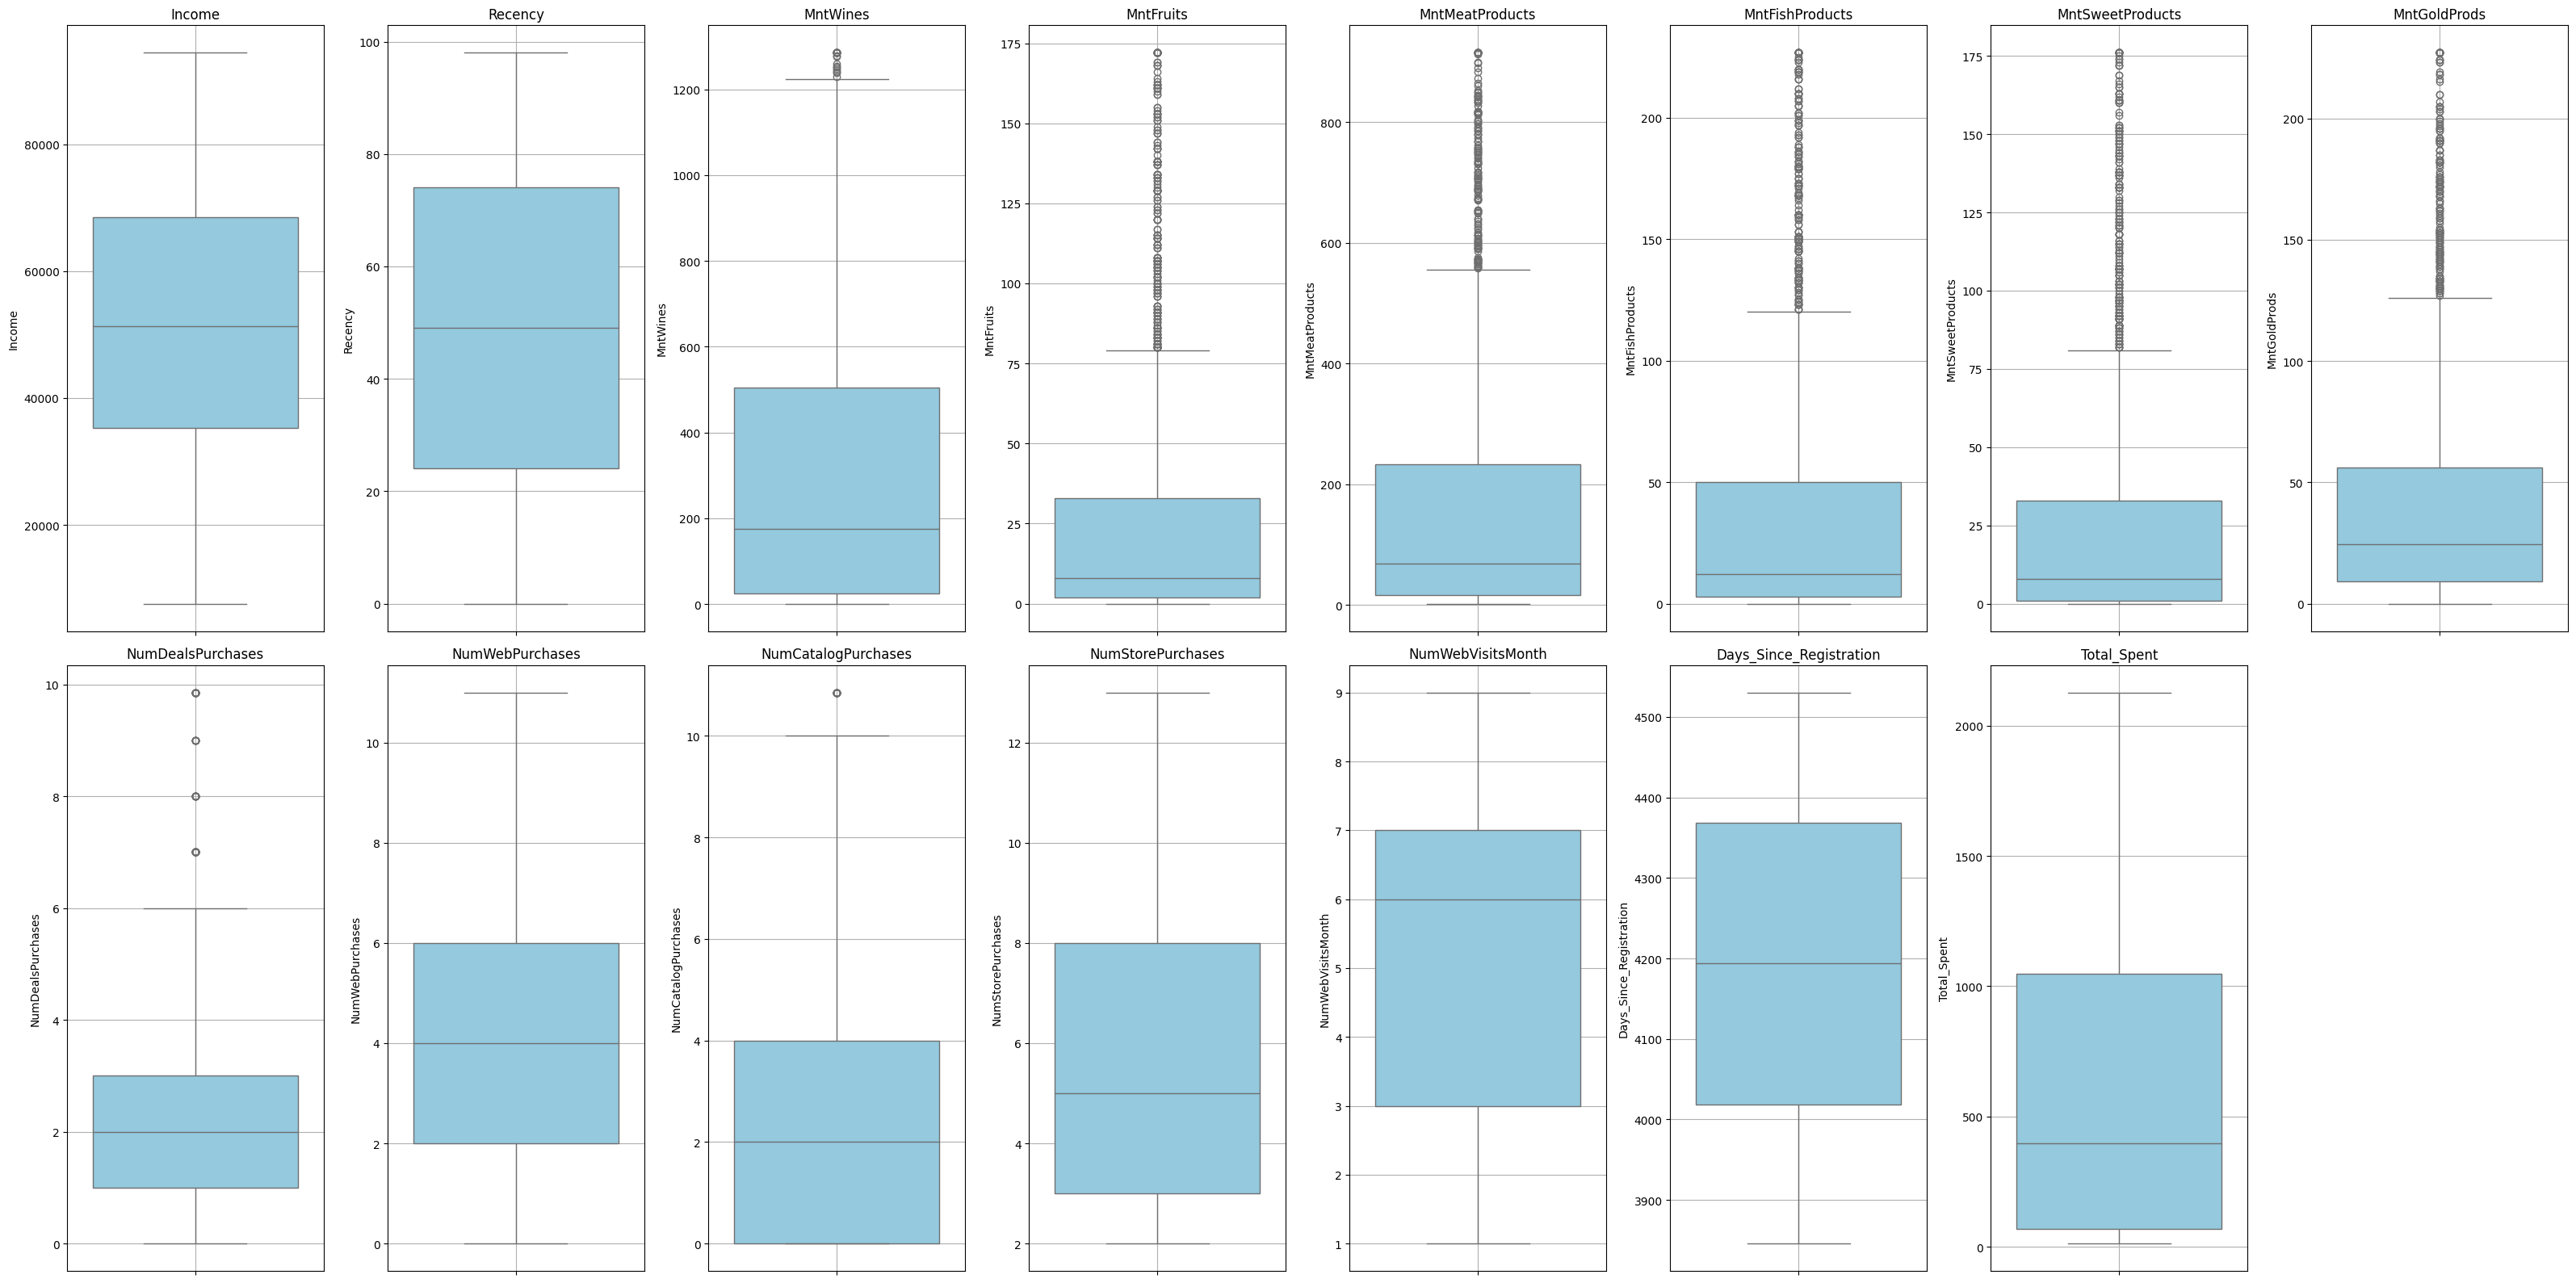

In [ ]:
columns = [col for col in list(df_clean.columns) if col not in exclude]
df_out = cap_outliers(df_clean, columns)

outliers_box(df_out, exclude)



---
# Exploratory Data Analysis (EDA)


### Heatmap

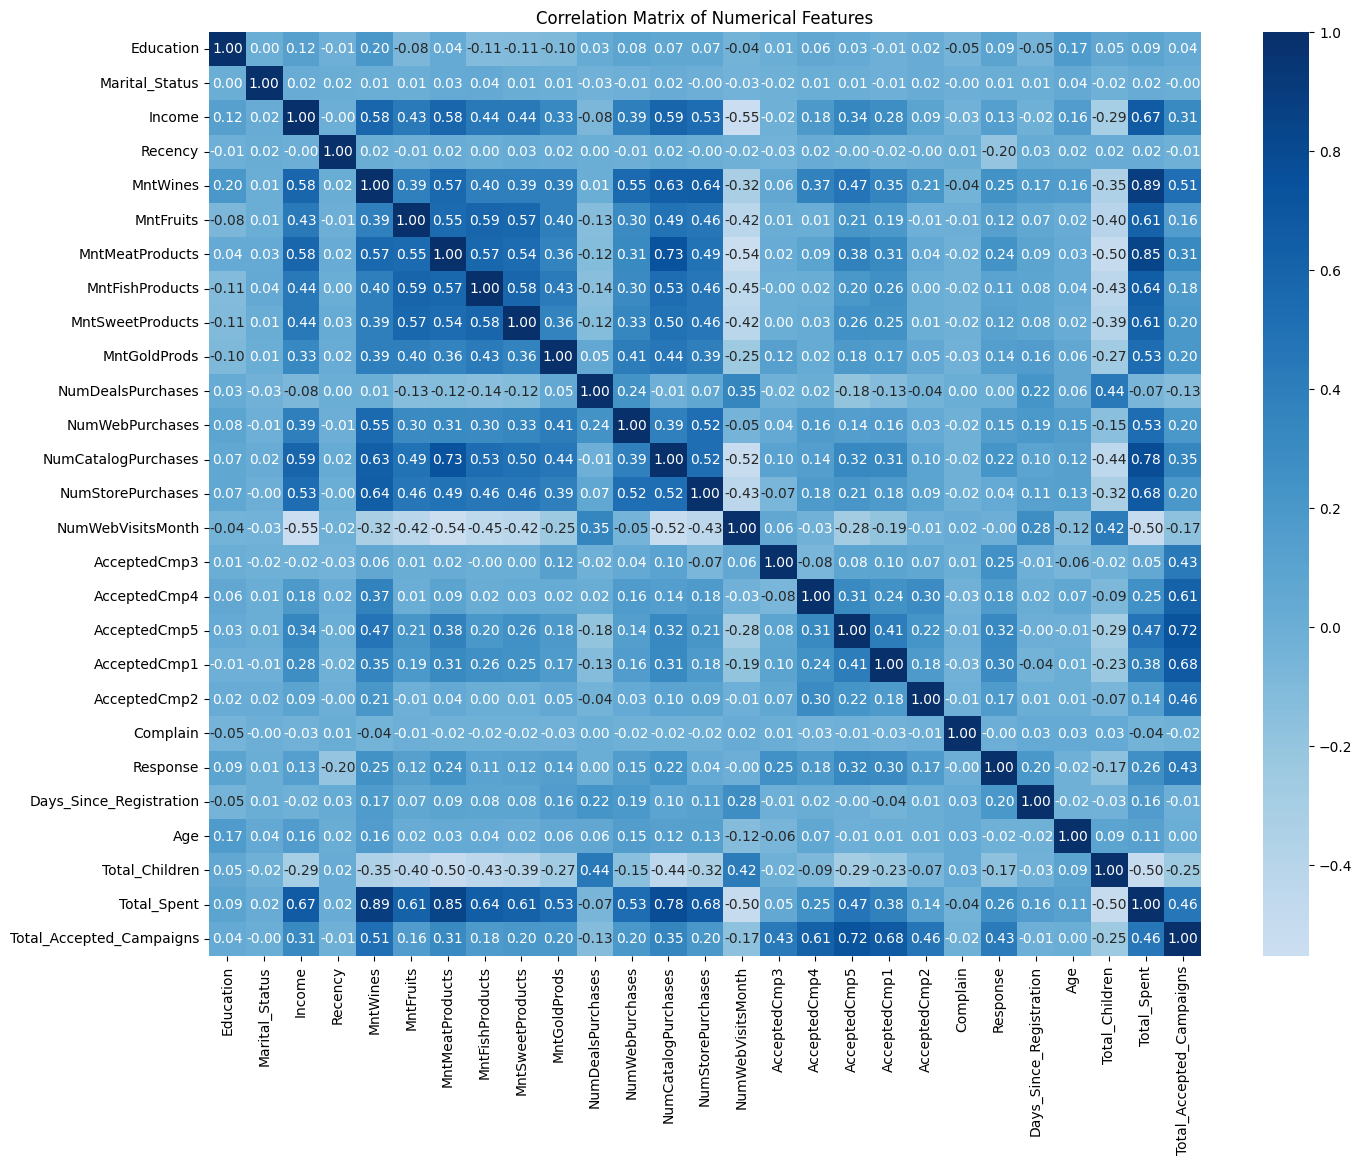

In [ ]:
numeric_df = df_clean.select_dtypes(include=['int64', 'float64'])
corr_matrix = numeric_df.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='Blues', center=0)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

### Clustering Strategy: Feature Selection (Excluding Campaign Response Variables)

Our goal is to segment customers into behaviorally distinct personas based on their purchases, engagement habits, and demographics — not based on their reaction to specific marketing campaigns.

#### Included Features

We include features that describe who the customer is and how they behave:

- **Spending Behavior**:
  - `MntWines`, `MntFruits`, `MntMeatProducts`, `MntFishProducts`, `MntSweetProducts`, `MntGoldProds`
    Represent direct product preferences and spending intensity.

- **Engagement & Purchase Channels**:
  - `NumDealsPurchases`, `NumWebPurchases`, `NumCatalogPurchases`, `NumStorePurchases`, `NumWebVisitsMonth`, `Recency`
    Capture how customers interact with different sales channels and how recent their activity is.

- **Demographics**:
  - `Age`, `Income`, `Total_Children`
    Provide important context for clustering into personas.

#### Excluded Features

We exclude:
- `AcceptedCmp1`, `AcceptedCmp2`, ..., `AcceptedCmp5`, `Response`, `Total_Accepted_Campaigns`
These are reaction-based features that reflect how a customer responded to a specific marketing action. Including them would distort the clusters by: overemphasizing campaign responsiveness as a primary factor, obscuring the natural behavioral structure we aim to uncover
- `Dt_Customer`
This is the original date that you've already converted to the Days_Since_Registration numeric variable.
- `Total_Spent`
This is a total value that directly depends on other columns (MntWines, MntFruits, ...). If left, it duplicates information and can artificially dominate PCA/KMeans.

#### Summary

This approach ensures that the resulting clusters represent intrinsic customer behaviors and not predefined outcomes. Once the clusters are formed, we can analyze campaign response post-clustering to assess which personas are more or less receptive to marketing initiatives.


In [ ]:
df_native = df_clean.drop(columns=['AcceptedCmp1',
                                   'AcceptedCmp2',
                                   'AcceptedCmp3',
                                   'AcceptedCmp4',
                                   'AcceptedCmp5',
                                   'Response',
                                   'Total_Accepted_Campaigns',
                                   'Total_Spent',
                                   'Dt_Customer'])
df_native.head()

,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Days_Since_Registration,Age,Total_Children
0,2,3,58138.0,58,635,88,546,172,88,88,3,8,10,4,7,0,4502,68,0
1,2,3,46344.0,38,11,1,6,2,1,6,2,1,1,2,5,0,3952,71,2
2,2,4,71613.0,26,426,49,127,111,21,42,1,8,2,10,4,0,4151,60,0
3,2,4,26646.0,26,11,4,20,10,3,5,2,2,0,4,6,0,3978,41,1
4,4,1,58293.0,94,173,43,118,46,27,15,5,5,3,6,5,0,4000,44,1


In [ ]:
# df_native.to_csv('testing.csv', index=False, sep=';')

# Preparation for clustering

---

Let`s plot distribution to analyze and choose which transformations we should realise

In [ ]:
def plot(df_cluster, columns, cols):

    n_cols = cols
    n_rows = int(np.ceil(len(columns) / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.histplot(df_cluster[col], bins=30, kde=True, ax=axes[i])


    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

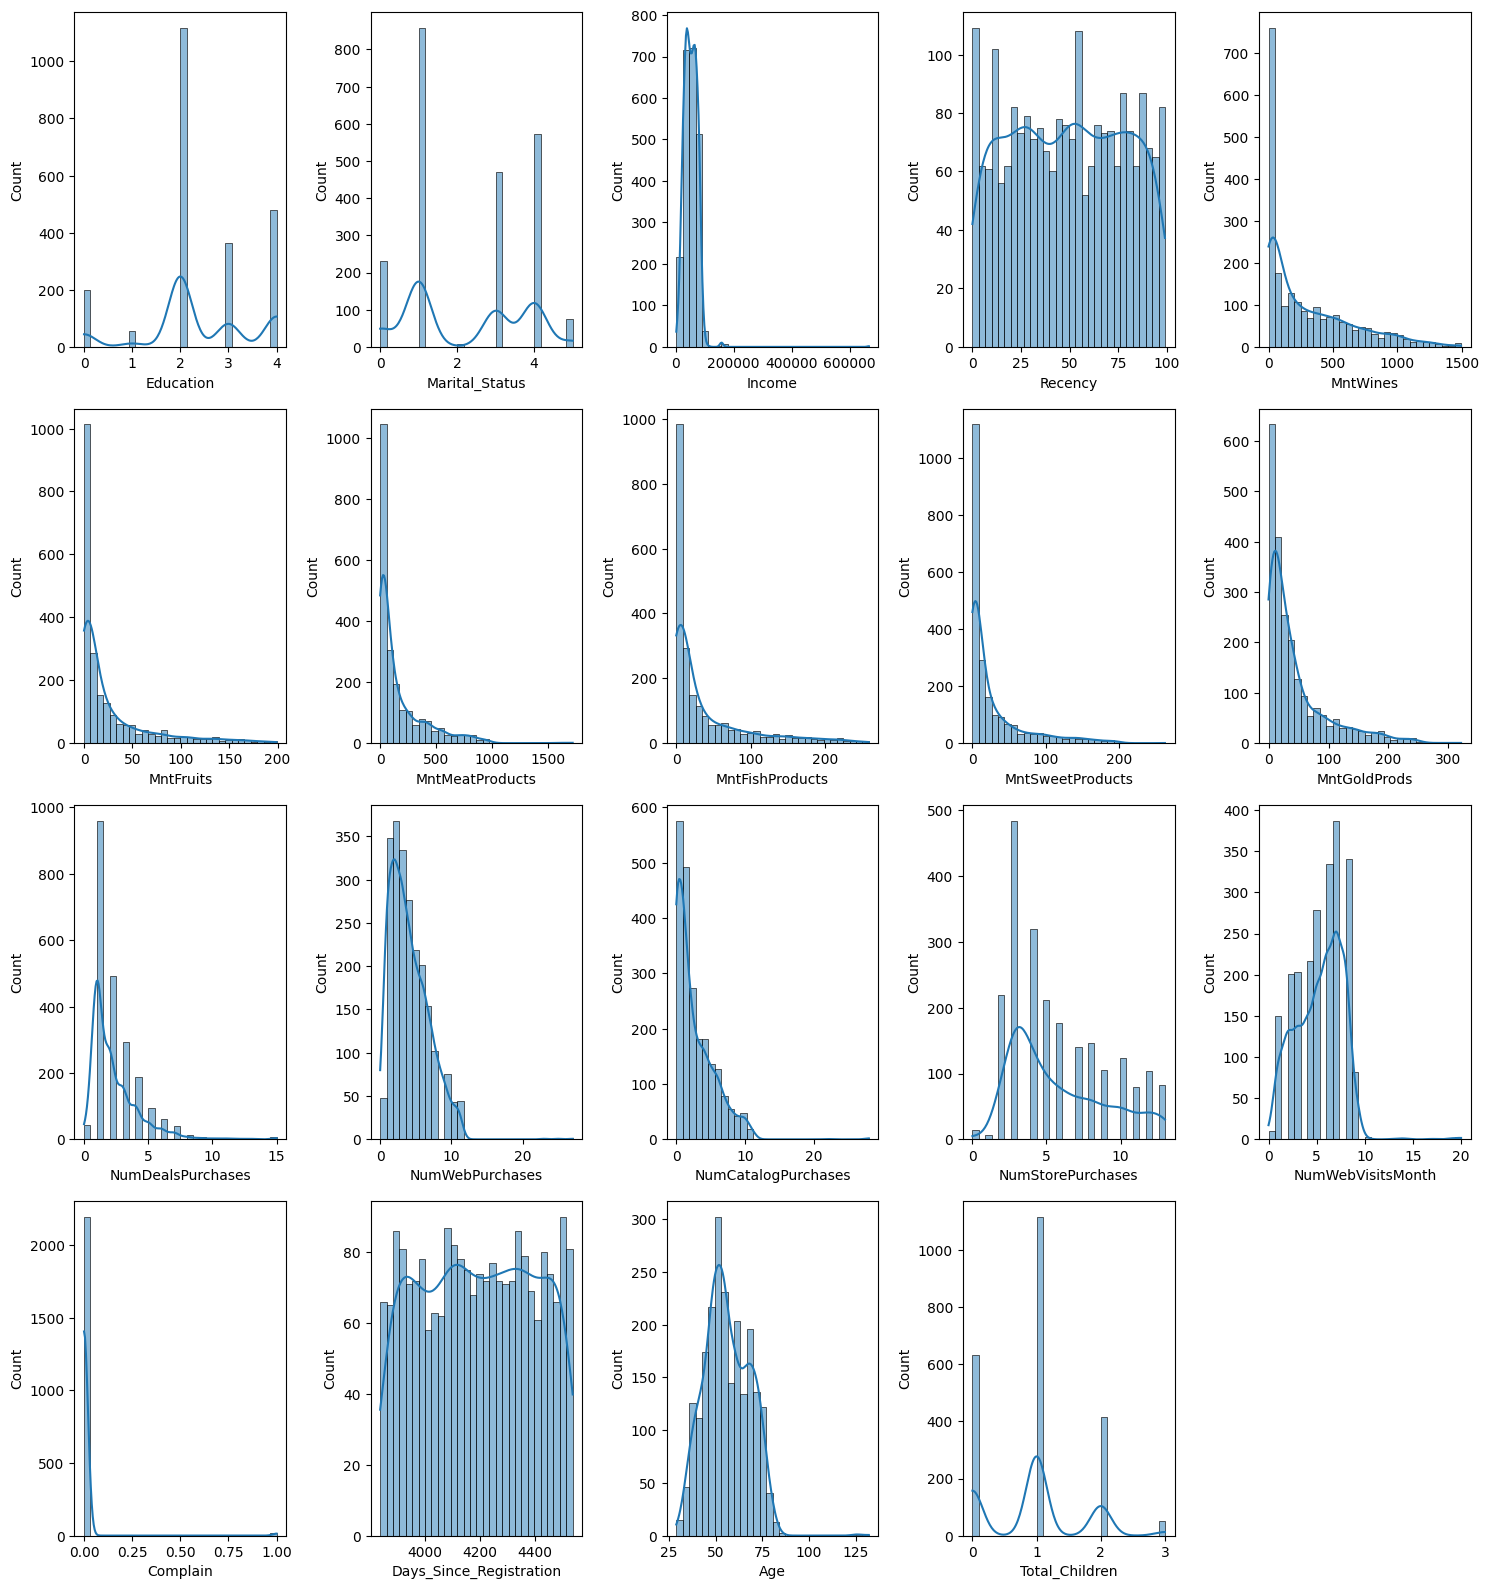

In [ ]:
plot(df_native, list(df_native.columns), 5)

### Feature Transformation Strategy Before Scaling

To prepare our dataset for clustering, we analyze each feature type and apply appropriate preprocessing:



#### Logarithmic Transformation

We apply `np.log1p()` to features that are **right-skewed** or have **high variance**, in order to compress large values and stabilize the distribution. This helps prevent dominant features from distorting cluster distances.

**Features to log-transform:**

- `Income` — strong positive skew, typical for income distributions.
- `MntWines`, `MntMeatProducts`, `MntFishProducts`, `MntSweetProducts`, `MntGoldProds` — all represent spending, show sharp skew and heavy tails.
- `NumCatalogPurchases`, `NumDealsPurchases`, `NumWebPurchases` — mostly low with a few large values.


#### Categorical Features (One-Hot Encoding)

Some features are **categorical**, even though currently encoded as integers via `LabelEncoder`. To preserve their discrete nature and avoid misleading distance calculations, we will apply **one-hot encoding**.

**Features to one-hot encode:**

- `Education` — ordinally encoded (0, 1, 2...), but should be treated as nominal categories.
- `Marital_Status` — categorical sociological states (e.g. Single, Married, Other).
- `Complain` — binary status, treated as categorical.


#### Leave as Is (to be scaled directly)

The following features are **continuous, numeric, and fairly normally distributed or discrete with narrow ranges**, and can be used as-is after standardization:

- `Age`
- `Total_Children`
- `Recency`
- `Days_Since_Registration`
- `NumDealsPurchases`
- `NumWebPurchases`
- `NumStorePurchases`
- `NumWebVisitsMonth`


By applying these transformations, we ensure that our feature space is balanced, meaningful, and ready for clustering using distance-based methods like KMeans or dimensionality reduction via PCA.


### Log-function

In [ ]:
log_features = [
    'Income',
    'MntWines', 'MntMeatProducts', 'MntFruits',
    'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
    'NumCatalogPurchases', 'NumDealsPurchases', 'NumWebPurchases'
]

In [ ]:
df_log = df_native
for col in log_features:
    df_log[col] = np.log1p(df_log[col])

### One-hot encoding
For One-Hot encoding realisation, we took original dataset without label coding for categorical features. After transformation, we added new one-hot encoded categorical features to the current dataset, and droped label-encoded.

In [ ]:
df_one_hot = df.copy()
df_one_hot = df_one_hot.dropna(subset=['Income'])
df_cat = df_one_hot[['Education', 'Marital_Status']].copy()

other = ['Alone', 'Absurd', 'YOLO']
df_cat['Marital_Status'] = df_cat['Marital_Status'].replace(other, 'Other')

df_cat_encoded = pd.get_dummies(
    df_cat,
    columns=['Education', 'Marital_Status'],
    prefix=['Education', 'Marital_Status'],
    prefix_sep='_',
    drop_first=True,
    dtype=int
)

df_log = df_log.drop(columns=['Education', 'Marital_Status'], errors='ignore')

df_log = pd.concat([df_log, df_cat_encoded], axis=1)

df_log.head()

# check length of both datasets

assert len(df_log) == len(df_clean)
assert (df_log.index == df_clean.index).all()

## Scaling

In [ ]:
scale_features = [
    'Income', 'Recency',
    'MntWines', 'MntMeatProducts', 'MntFruits',
    'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
    'NumCatalogPurchases', 'NumDealsPurchases', 'NumWebPurchases',
    'NumStorePurchases', 'NumWebVisitsMonth',
    'Days_Since_Registration', 'Age', 'Total_Children'
]

scaler = StandardScaler()

df_scaled_part = pd.DataFrame(
    scaler.fit_transform(df_log[scale_features]),
    columns=scale_features,
    index=df_log.index
)

df_rest = df_log.drop(columns=scale_features)

df_scaled = pd.concat([df_scaled_part, df_rest], axis=1)

In [ ]:
# df_scaled.to_csv('testing_scaled.csv', index=False, sep=';')

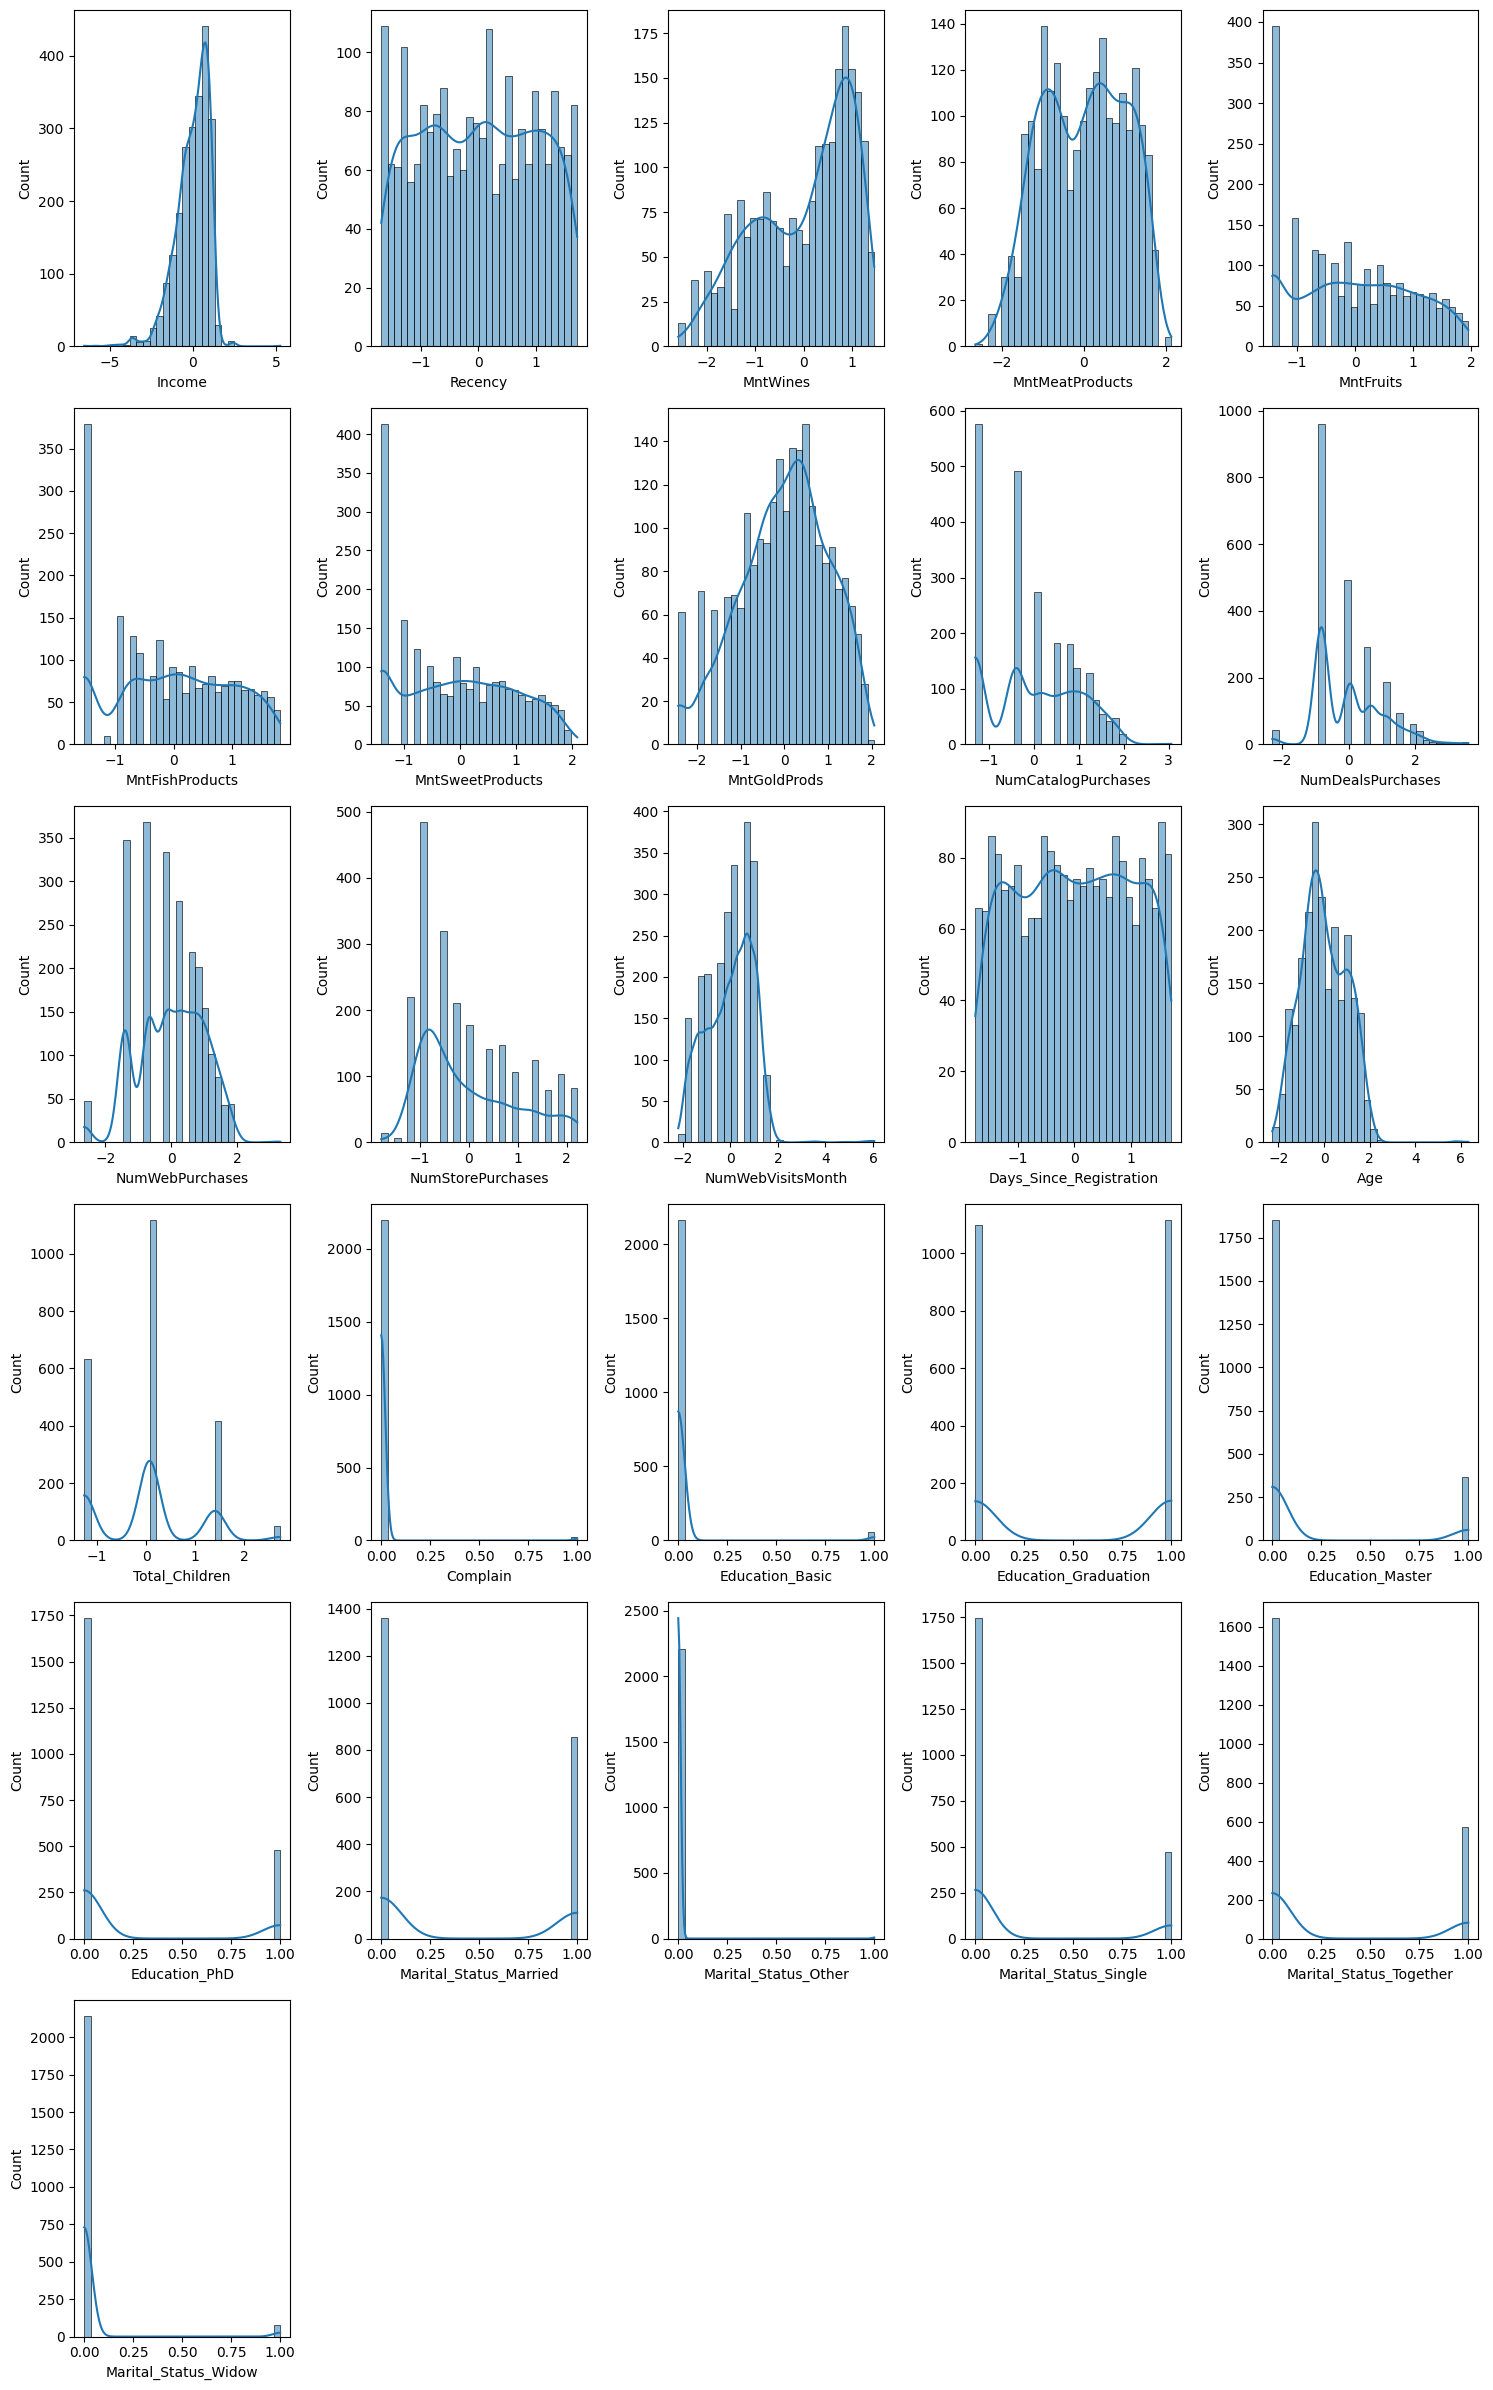

In [ ]:
plot(df_scaled, list(df_scaled.columns), 5)

## Dimensionality Reduction: PCA and UMAP

Before applying clustering algorithms, we perform dimensionality reduction using **PCA (Principal Component Analysis)** and **UMAP (Uniform Manifold Approximation and Projection)**.

These techniques allow us to:

- Visualize high-dimensional data in 2D space
- Evaluate if the data form natural clusters
- Identify dominant axes of variation in the dataset
- Explore the structure and separability of customer segments

#### PCA
- A linear technique that projects data onto directions of maximum variance
- Preserves global structure
- Useful for understanding overall variance distribution

#### UMAP
- A nonlinear method that preserves local neighborhood structure
- Captures more complex, curved relationships
- Often reveals tighter and more meaningful clusters for visualization

> By comparing the results of PCA and UMAP, we can better understand the geometry of the customer dataset and evaluate the potential for meaningful segmentation.


In [ ]:
class ReduceFeatures:

    def __init__(self, embeddings, method, n_components, n_neighbors=10, min_dist=0.05):
        self.embeddings = embeddings
        self.n_components = n_components
        self.n_neighbors = n_neighbors
        self.min_dist = min_dist

        match method:
            case 'pca':
                self.reducer = PCA(n_components=self.n_components)
            case 'umap':
                self.reducer = UMAP(n_components=self.n_components, n_neighbors=self.n_neighbors, min_dist=self.min_dist)

    def reduce_it(self):

        reduced = self.reducer.fit_transform(self.embeddings)
        return reduced

### Check missing

In [ ]:
df_scaled.isna().sum().sort_values(ascending=False).head()


,0
Income,0
Recency,0
MntWines,0
MntMeatProducts,0
MntFruits,0


### Fill it by mean values

In [ ]:
df_scaled = df_scaled.fillna(df_scaled.mean(numeric_only=True))

### Making 2D reducing

In [ ]:
reducer_pca = ReduceFeatures(df_scaled, 'pca', 2)
X_pca = reducer_pca.reduce_it()

reducer_umap = ReduceFeatures(df_scaled, 'umap', 2)
X_umap = reducer_umap.reduce_it()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Visualization

In [ ]:
def plot_2d_projection(X_2d, title='2D Projection', color=None):
    plt.figure(figsize=(8, 6))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=color, cmap='viridis', s=10, alpha=0.8)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

<ipython-input-30-86760fc41e15>:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_2d[:, 0], X_2d[:, 1], c=color, cmap='viridis', s=10, alpha=0.8)


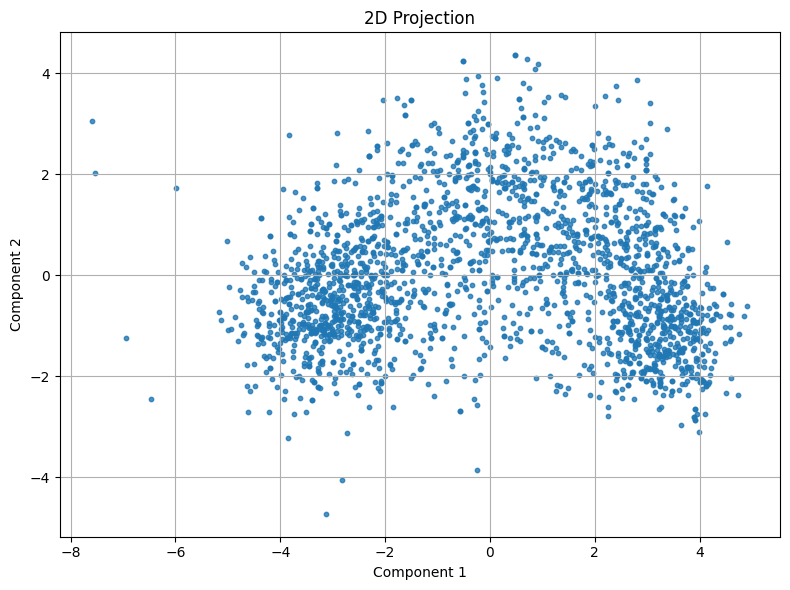

In [ ]:
plot_2d_projection(X_pca)

<ipython-input-30-86760fc41e15>:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_2d[:, 0], X_2d[:, 1], c=color, cmap='viridis', s=10, alpha=0.8)


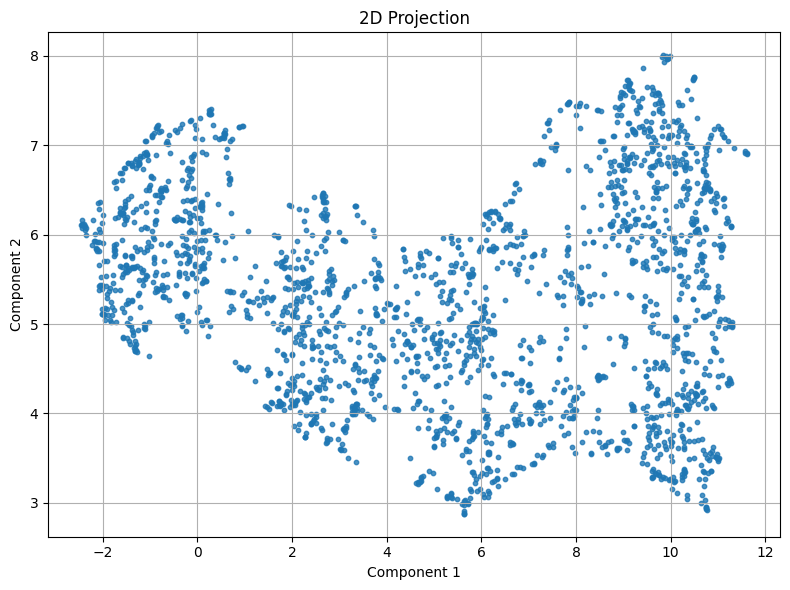

In [ ]:
plot_2d_projection(X_umap)

We applied two dimensionality reduction techniques — **PCA** and **UMAP** — to project high-dimensional customer data into a 2D space.

- **PCA (Principal Component Analysis)** captures the directions of maximum variance. The result is more "globally linear", showing overall structure but not necessarily clustering well.
- **UMAP (Uniform Manifold Approximation and Projection)** preserves both local and global relationships better than PCA and is more suited for discovering complex cluster patterns.

Both projections serve as a useful sanity check before applying clustering algorithms. They help us visually estimate the number of potential clusters and evaluate the separability of different customer groups.


### Making 3D reducing

In [ ]:
reducer_pca_3d = ReduceFeatures(df_scaled, 'pca', 3)
X_pca_3d = reducer_pca_3d.reduce_it()

reducer_umap_3d = ReduceFeatures(df_scaled, 'umap', 3)
X_umap_3d = reducer_umap_3d.reduce_it()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### 3D Visualization

In [ ]:
def plot_3d_projection(X_3d, title='3D Interactive Projection', color=None):

    scatter = go.Scatter3d(
        x=X_3d[:, 0],
        y=X_3d[:, 1],
        z=X_3d[:, 2],
        mode='markers',
        marker=dict(
            size=3,
            color=color,
            colorscale='Viridis',
            opacity=0.7
        )
    )

    fig = go.Figure(data=[scatter])
    fig.update_layout(
        title=title,
        scene=dict(
            aspectmode='cube',
            xaxis_title='Component 1',
            yaxis_title='Component 2',
            zaxis_title='Component 3'
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )
    fig.show()



In [ ]:
plot_3d_projection(X_pca_3d, title='PCA 3D Projection')

In [ ]:
plot_3d_projection(X_umap_3d, title='UMAP 3D Projection')

# Clustering
---

## Comparison of Key Algorithms

In this stage, we will evaluate several key clustering algorithms to identify the most suitable one for our dataset. The goal is to assess the clustering quality and choose the best method for final 3D visualization.

### Algorithms to Compare

1. **KMeans**
   - A simple and fast method that minimizes intra-cluster distance.
   - Key parameters: `n_clusters`, `init`, `n_init`.

2. **DBSCAN**
   - Density-based clustering that identifies clusters of closely packed points.
   - Advantage: does not require specifying the number of clusters.
   - Key parameters: `eps`, `min_samples`.

3. **Agglomerative Clustering**
   - A hierarchical clustering model that merges clusters based on similarity.
   - Key parameters: `n_clusters`, `affinity` `linkage`.

4. **HDBSCAN**
   - An enhanced version of DBSCAN that builds a cluster hierarchy and selects clusters automatically.
   - Key parameters: `min_cluster_size`, `min_samples`.

5. **Gaussian Mixture Models (GMM)**
   - A probabilistic model that fits data as a mixture of multiple Gaussian distributions.
   - Key parameters: `n_components`, `covariance_type`.

### Plan of Action

1. Perform clustering in the original feature space.
2. Visualize clustering results on 2D projection (using UMAP or PCA).
3. Compare outcomes visually and with clustering metrics (if needed).
4. Select the best method and visualize the result in 3D.


### To choose quantity of clusters we use elbow method

In [ ]:
def plot_elbow(X, k_range=range(2, 16)):
    inertias = []
    for k in k_range:
        model = KMeans(n_clusters=k, n_init=10, random_state=42)
        model.fit(X)
        inertias.append(model.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(list(k_range), inertias, marker='o')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.xticks(list(k_range))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

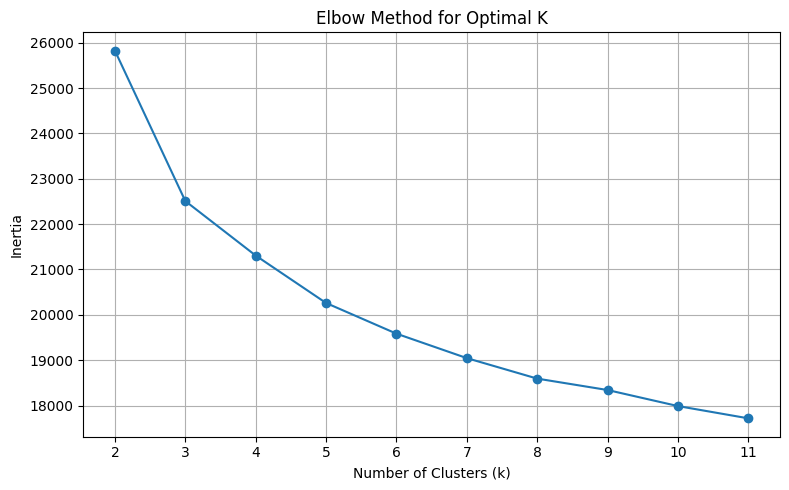

In [ ]:
plot_elbow(df_scaled, k_range=range(2, 12))

### Elbow Method Feedback

The elbow plot above shows the relationship between the number of clusters (k) and the corresponding inertia (within-cluster sum of squares). Here's a quick analysis:

- There is a clear "elbow" or point of inflection visible around **k = 3**.
- This suggests that increasing the number of clusters around **k = 3** results in diminishing returns in terms of reducing inertia.
- Therefore, **k = 3** appears to be an optimal choice for the KMeans algorithm, as it balances model simplicity with cluster compactness.

This value will be used as a baseline when comparing clustering performance across other algorithms.


## K-means
---

In [ ]:
model_kmeans = KMeans(n_clusters=3, random_state=42)
labels_kmeans = model_kmeans.fit_predict(df_scaled)

In [ ]:
plot_3d_projection(X_umap_3d, color=labels_kmeans)

## Agglomerative Clustering
---

In [ ]:
model_ac = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
labels_ac = model_ac.fit_predict(df_scaled)

In [ ]:
plot_3d_projection(X_umap_3d, color=labels_ac)

## Gaussian Mixture Models (GMM)
---

In [ ]:
model_gmm = GaussianMixture(n_components=3, covariance_type='spherical', random_state=42)
labels_gmm = model_gmm.fit_predict(df_scaled)

In [ ]:
plot_3d_projection(X_umap_3d, color=labels_gmm)

## DBSCAN

In [ ]:
model_dbscan = DBSCAN(eps=0.2, min_samples=13, metric='cosine')
labels_dbscan = model_dbscan.fit_predict(df_scaled)

In [ ]:
plot_3d_projection(X_umap_3d, color=labels_dbscan)

## HDBSCAN

In [ ]:
model_hdb = HDBSCAN(
    min_cluster_size=50,
    min_samples=25,
    metric='cosine',
    cluster_selection_method='eom'
)
labels_hdb = model_hdb.fit_predict(df_scaled)

In [ ]:
plot_3d_projection(X_umap_3d, color=labels_hdb)

# Clustering Evaluation Plan

---

## 1. Objectives

- **Assess cluster quality** using internal validation metrics.
- **Identify the most stable and informative clustering algorithm**.
- **Understand the shape, cohesion, and separation** of the clusters formed.
- **Visualize strengths and weaknesses** of different clustering strategies (e.g., KMeans, GMM, DBSCAN, HDBSCAN).


## 2. Clustering Algorithms to Compare

- **KMeans**
- **Agglomerative Clustering**
- **Gaussian Mixture Models (GMM)**
- **DBSCAN**
- **HDBSCAN**



## 3. Internal Validation Metrics

### 3.1 Silhouette Score
- Measures cohesion vs separation of clusters.
- Values range from -1 to 1; higher is better.

### 3.2 Calinski-Harabasz Index
- Ratio of between-cluster dispersion to within-cluster dispersion.
- Higher values indicate better-defined clusters.

### 3.3 Davies-Bouldin Index
- Average similarity between each cluster and its most similar one.
- Lower values indicate better clustering.



In [ ]:
def evaluate_clustering_models(X, model_labels):

    results = []

    for name, labels in model_labels.items():
        sil_score = silhouette_score(X, labels)
        ch_score = calinski_harabasz_score(X, labels)
        db_score = davies_bouldin_score(X, labels)

        results.append({
            'Model': name,
            'Silhouette': sil_score,
            'Calinski-Harabasz': ch_score,
            'Davies-Bouldin': db_score,
            'Clusters': len(set(labels)) - (1 if -1 in labels else 0)
        })

    return pd.DataFrame(results).sort_values(by="Silhouette", ascending=False)


In [ ]:
model_labels = {
    "KMeans": labels_kmeans,
    "Agglomerative": labels_ac,
    "GMM": labels_gmm,
    "DBSCAN": labels_dbscan,
    "HDBSCAN": labels_hdb
}

In [ ]:
results_df = evaluate_clustering_models(df_scaled, model_labels)

### Melting

In [ ]:
df_melted = results_df.melt(id_vars='Model', value_vars=['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin'],
                            var_name='Metric', value_name='Score')

## Visualization

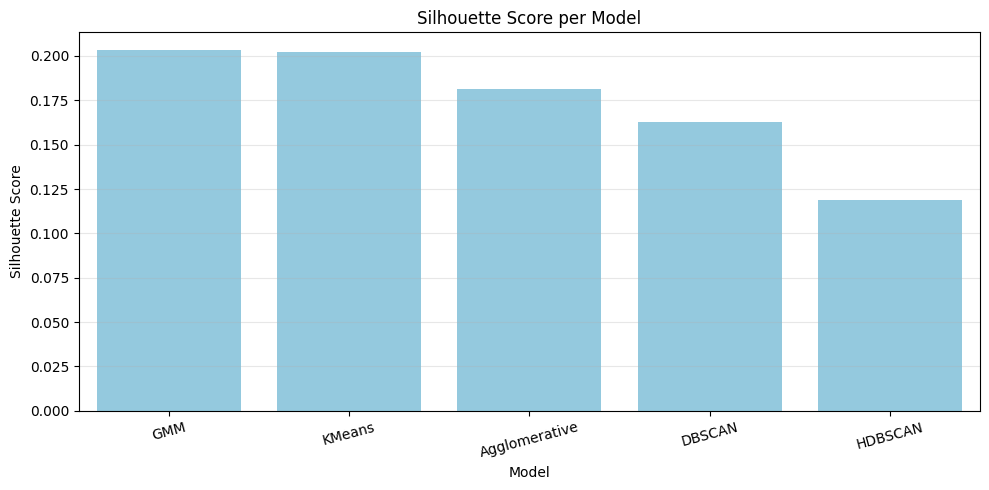

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Model', y='Silhouette', color='skyblue')
plt.title('Silhouette Score per Model')
plt.ylabel('Silhouette Score')
plt.xticks(rotation=15)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


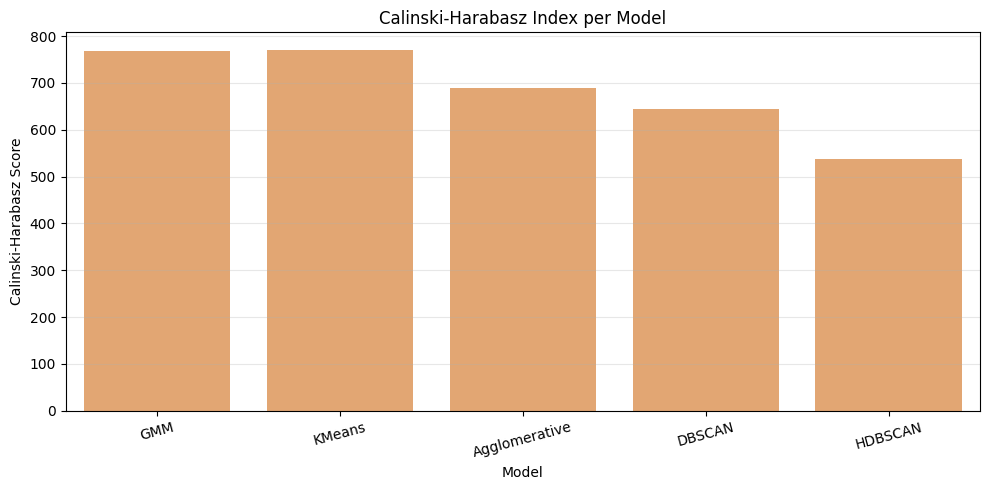

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Model', y='Calinski-Harabasz', color='sandybrown')
plt.title('Calinski-Harabasz Index per Model')
plt.ylabel('Calinski-Harabasz Score')
plt.xticks(rotation=15)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

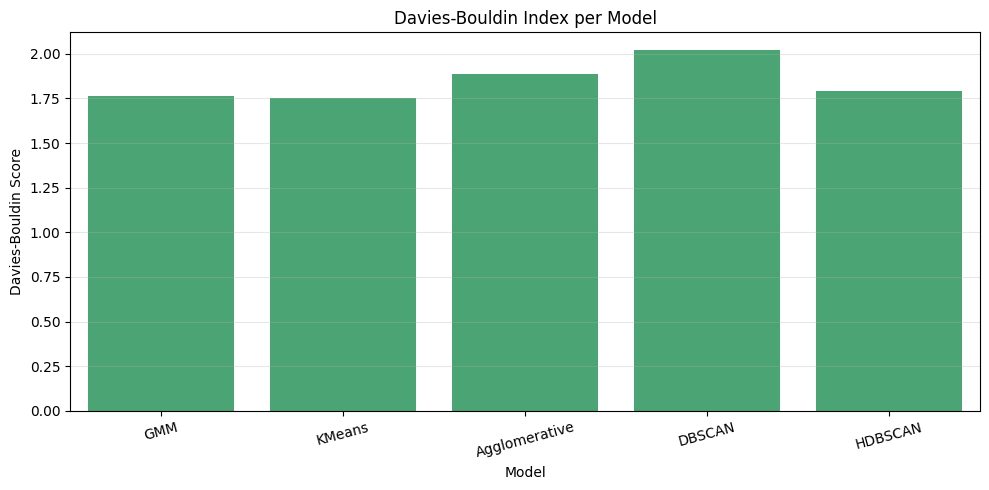

In [ ]:
# Davies-Bouldin
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Model', y='Davies-Bouldin', color='mediumseagreen')
plt.title('Davies-Bouldin Index per Model')
plt.ylabel('Davies-Bouldin Score')
plt.xticks(rotation=15)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Visualization of clustering methods with higher results

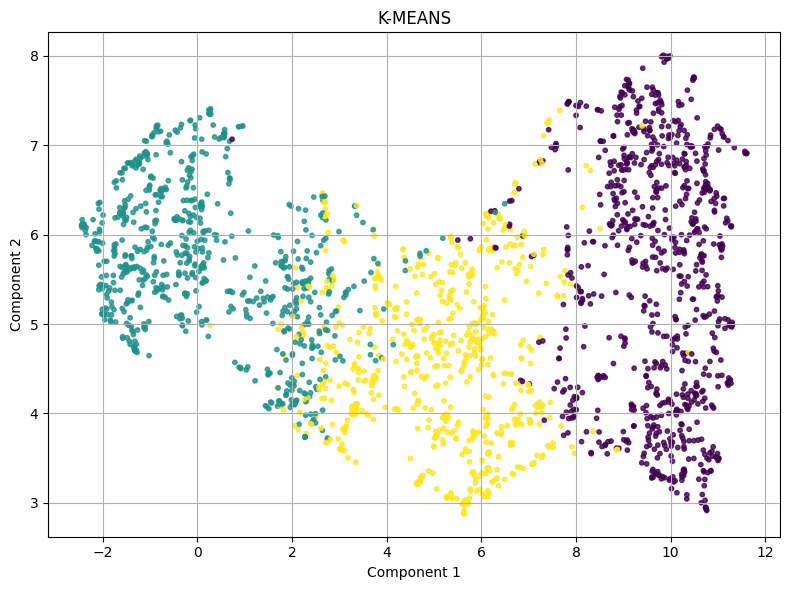

In [ ]:
plot_2d_projection(X_umap, title='K-MEANS', color=labels_kmeans)

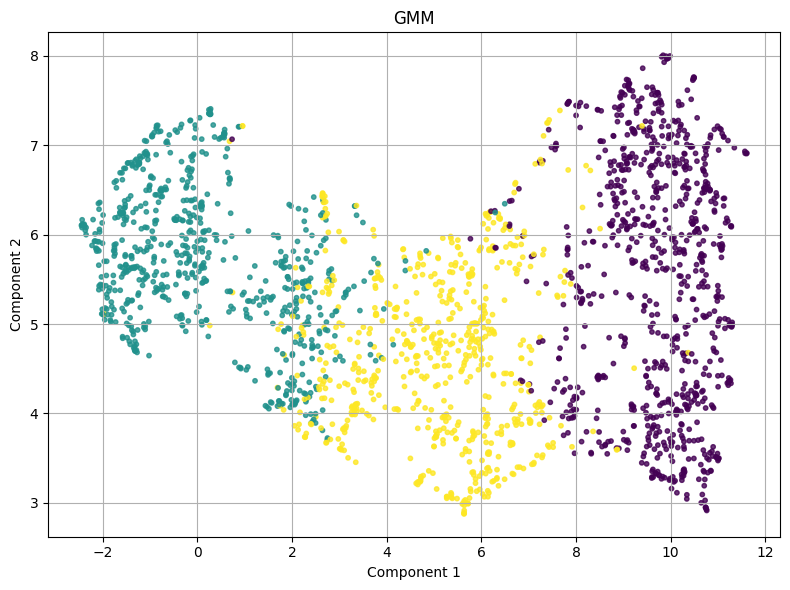

In [ ]:
plot_2d_projection(X_umap, title='GMM', color=labels_gmm)

## Clustering Quality Evaluation Report
---

We evaluated five clustering algorithms (KMeans, GMM, Agglomerative, DBSCAN, HDBSCAN) using three internal metrics and 2D UMAP visualizations of better methods. Below is a summary of our findings.

### 1. Silhouette Score
- **Interpretation**: Measures how similar a point is to its own cluster compared to other clusters. Higher is better.
- **Observation**: KMeans and GMM models achieved scores (~0.20). It`s higher than scores of other models, but this result is not really high at all. It is indicating weak separation or overlapping clusters.
- **Conclusion**: Low silhouette values suggest that the inter-cluster distances are not significantly larger than intra-cluster compactness.

### 2. Calinski-Harabasz Index
- **Interpretation**: Ratio of between-cluster dispersion to within-cluster dispersion. Higher is better.
- **Observation**: GMM and KMeans achieved the highest values (~770), indicating well-separated cluster centers.
- **Conclusion**: High CH values confirm strong between-cluster separation, although this metric assumes spherical clusters.

### 3. Davies-Bouldin Index
- **Interpretation**: Represents the average similarity between each cluster and its most similar one. Lower is better.
- **Observation**: GMM and KMeans produced the lowest scores (~1.75).
- **Conclusion**: Clusters show moderate overlap, with some degree of internal variance.

### 4. 2D UMAP Visualization
- **KMeans**: Three clearly defined clusters with minimal overlap. Good spatial separation.
- **GMM**: Similar structure, but with smoother transitions between clusters, as expected from a probabilistic model.

### 🔎 Summary Table

| Model         | Silhouette ↑ | Calinski-Harabasz ↑ | Davies-Bouldin ↓ | Visual Separation |
|---------------|---------------|----------------------|-------------------|--------------------|
| **GMM**        | ~0.20         | ~770                 | ~1.75             | Moderate-Strong    |
| **KMeans**     | ~0.20         | ~765                 | ~1.75             | Strong             |
| Agglomerative  | ~0.19         | ~710                 | ~1.82             | Moderate           |
| DBSCAN         | ~0.16         | ~650                 | ~2.00             | Weak-Moderate      |
| HDBSCAN        | ~0.11         | ~550                 | ~1.78             | Weak               |

### Final Conclusion
Despite relatively low Silhouette scores, both **KMeans** and **GMM** demonstrate the best overall clustering quality based on a combination of metric performance and visual inspection. The clusters are well-separated spatially, and the CH and DB indices support the validity of the clustering structure. The Silhouette score is likely penalized by overlapping boundaries and complex cluster shapes.



In [ ]:
assert len(df_scaled) == len(df_clean)
assert (df_scaled.index == df_clean.index).all()

### Customer portrait analyse

In [ ]:
df_portrait = df_clean.copy()
df_portrait['Cluster_KMeans'] = labels_kmeans

In [ ]:
df_portrait.groupby('Cluster_KMeans').mean(numeric_only=True)

,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Days_Since_Registration,Age,Total_Children,Total_Spent,Total_Accepted_Campaigns
Cluster_KMeans,,,,,,,,,,,,,,,,,,,,,
0,2.259740,2.192444,33007.658796,48.480519,24.942149,3.773318,18.662338,5.253837,4.177096,12.094451,...,0.000000,0.000000,0.002361,0.014168,0.074380,4145.389610,53.153483,1.230224,68.903188,0.082645
1,2.396957,2.305671,72977.890733,49.181189,565.885201,62.443983,390.526971,89.775934,64.233748,73.275242,...,0.200553,0.160443,0.022130,0.008299,0.224066,4186.401107,57.360996,0.331950,1246.141079,0.556017
2,2.566563,2.216718,54271.527864,49.521672,380.529412,15.575851,111.308050,21.744582,15.351393,52.948916,...,0.026316,0.040248,0.018576,0.004644,0.167183,4261.167183,58.825077,1.264706,597.458204,0.292570


### Visualization

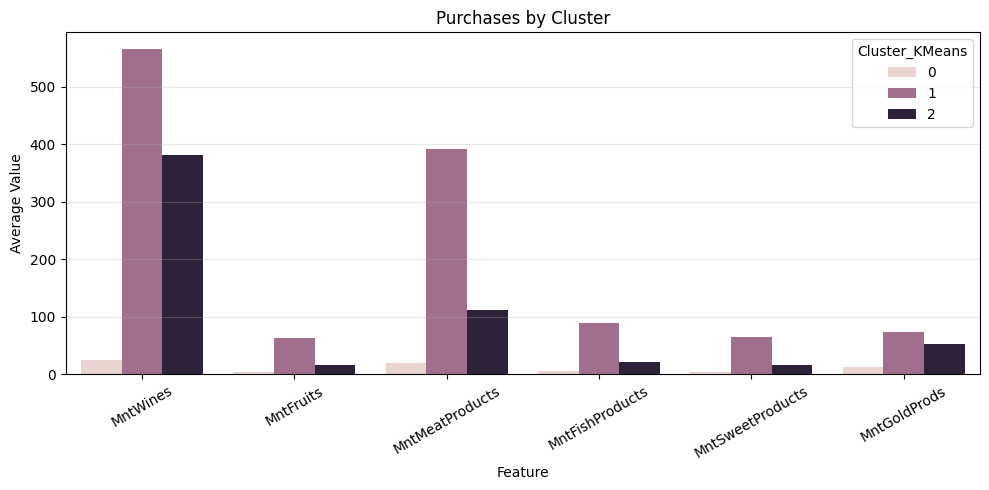

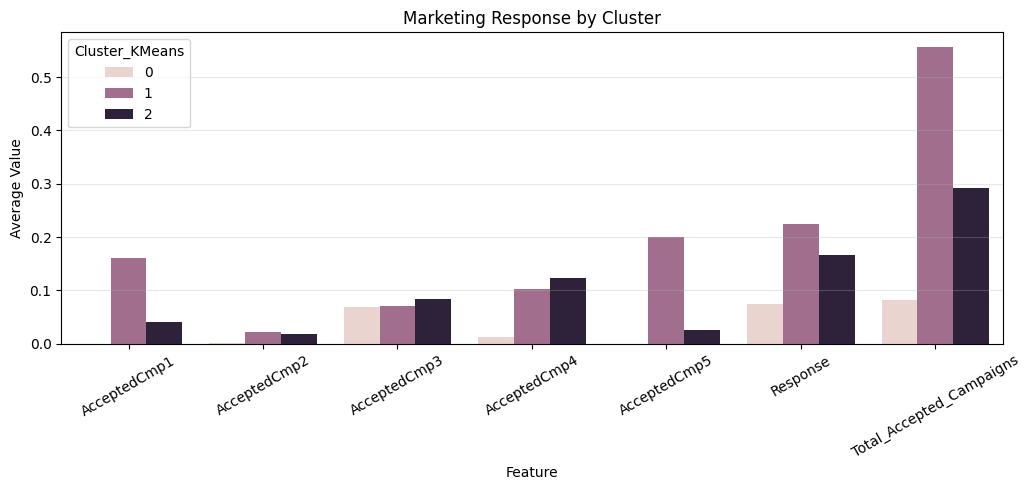

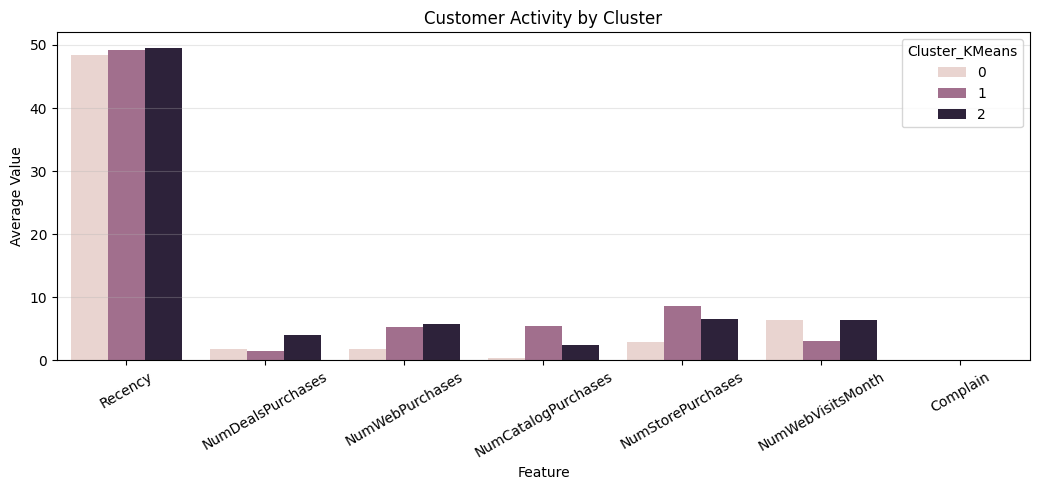

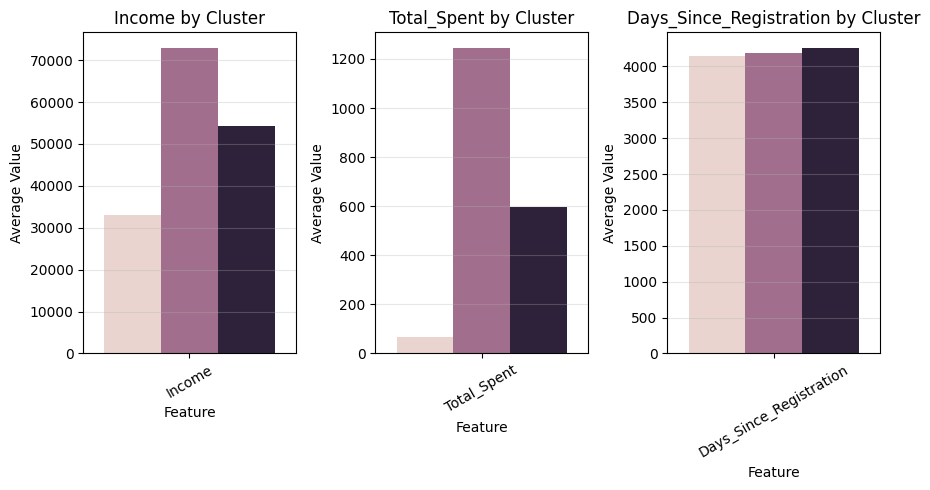

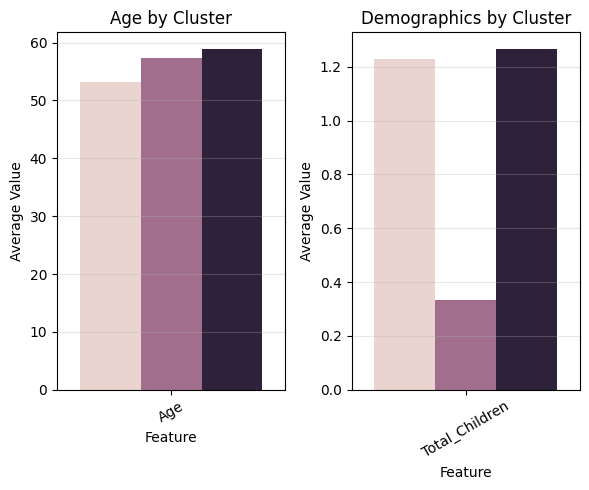

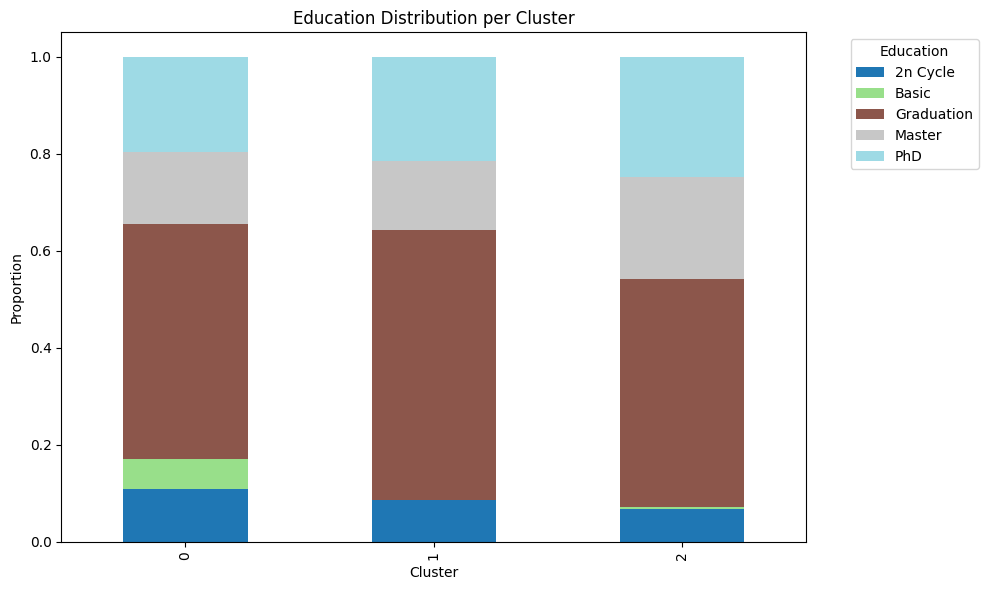

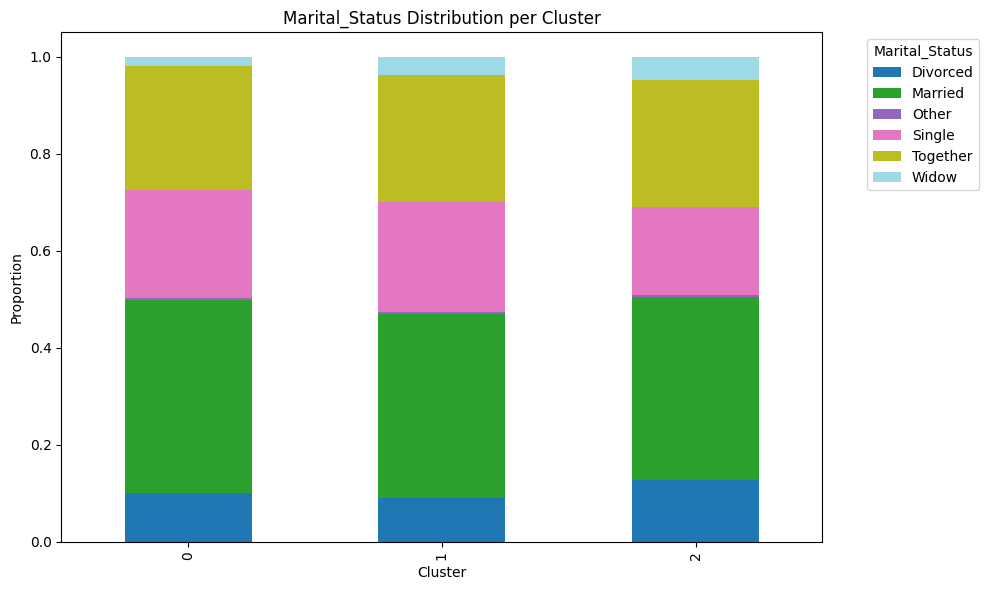

In [ ]:
# print(education_mapping)
# print(marital_mapping_cleaned)

groups = {
    'Income': ['Income'],'Total_Spent': ['Total_Spent'],
    'Days_Since_Registration': ['Days_Since_Registration'],
    'Purchases': ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
                  'MntSweetProducts', 'MntGoldProds'],
    'Marketing Response': ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4',
                           'AcceptedCmp5', 'Response', 'Total_Accepted_Campaigns'],
    'Customer Activity': ['Recency', 'NumDealsPurchases', 'NumWebPurchases',
                          'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
                           'Complain'],
    'Age': ['Age'],
    'Demographics': ['Total_Children'],
}

# --------------------------------------------------------------------------------------------------------------

cluster_column = 'Cluster_KMeans'
grouped = df_portrait.groupby(cluster_column)

plots_small = []  # For subplot groups
plots_wide = []   # For full-width individual plots

# Melting - prepare grouped data for logical feature group
for group_name, columns in groups.items():
    df_plot = grouped[columns].mean().reset_index().melt(
        id_vars=cluster_column,
        value_vars=columns,
        var_name='Feature',
        value_name='Average Value'
    )

    # Plot separately or in a subplot group
    if len(columns) >= 6:
        plots_wide.append((group_name, df_plot, len(columns)))
    else:
        plots_small.append((group_name, df_plot, len(columns)))

# Plot wide groups individual
for group_name, df_plot, num_features in plots_wide:
    width = max(10, num_features * 1.5)
    plt.figure(figsize=(width, 5))
    sns.barplot(data=df_plot, x='Feature', y='Average Value', hue=cluster_column)
    plt.title(f'{group_name} by Cluster')
    plt.xticks(rotation=30)
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot smaller groups as subplots
cols_per_row = 3
for i in range(0, len(plots_small), cols_per_row):
    batch = plots_small[i:i + cols_per_row]

    # Calculate total figure width
    widths = [max(1, p[2]) for p in batch]
    total_width = sum(widths)
    fig, axes = plt.subplots(1, len(batch), figsize=(3 * total_width, 5))

    if len(batch) == 1:
        axes = [axes]

    for ax, (group_name, df_plot, _) in zip(axes, batch):
        sns.barplot(data=df_plot, x='Feature', y='Average Value', hue=cluster_column, ax=ax)
        ax.set_title(f'{group_name} by Cluster')
        ax.tick_params(axis='x', rotation=30)
        ax.grid(True, axis='y', alpha=0.3)
        ax.get_legend().remove()

    plt.tight_layout()
    plt.show()

# Plot categorical features
# --------------------------------------------------------------------------------------------------------------

education_map = {
    0: '2n Cycle', 1: 'Basic', 2: 'Graduation', 3: 'Master', 4: 'PhD'
}

marital_status_map = {
    0: 'Divorced', 1: 'Married', 2: 'Other', 3: 'Single', 4: 'Together', 5: 'Widow'
}

# --------------------------------------------------------------------------------------------------------------

def plot_categorical_distribution(df, column, cluster_column='Cluster_KMeans'):

    if column == 'Education':
        label_map = education_map
    elif column == 'Marital_Status':
        label_map = marital_status_map
    else:
        label_map = {}

    dist = (
        df.groupby(cluster_column)[column]
        .value_counts(normalize=True)
        .unstack()
        .fillna(0)
        .sort_index(axis=1)
    )

    if label_map:
        dist.columns = [label_map.get(val, val) for val in dist.columns]

    dist.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
    plt.title(f'{column} Distribution per Cluster')
    plt.ylabel('Proportion')
    plt.xlabel('Cluster')
    plt.legend(title=column, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_categorical_distribution(df_portrait, 'Education')
plot_categorical_distribution(df_portrait, 'Marital_Status')

## Customer Segmentation Analysis – Final Cluster Profiles
---

Based on the KMeans clustering and feature visualizations, we identified three distinct customer segments. Below is a summary of each cluster profile derived from demographic, behavioral, and marketing response attributes.

### 🟡 **Cluster 0 – Low-Income Passive Shoppers**
- **Purchasing Behavior**: Lowest spending across all product categories, especially wines, meat, and fish.
- **Income**: Lowest average income (~33,000).
- **Marketing Response**: Minimal engagement with campaigns; almost no reactions.
- **Demographics**: Slightly younger average age (~53), typically have 1+ children.
- **Education & Status**: Higher share of basic education; more single or divorced individuals.
- **Customer Insight**: This group is financially constrained and disengaged from marketing. Not the ideal target for premium or campaign-driven strategies.


### 🟢 **Cluster 1 – High-Income Engaged Buyers**
- **Purchasing Behavior**: Highest expenditure, especially on **Wines (~550)** and **Meat (~390)**.
- **Income**: Highest among all clusters (~73,000).
- **Marketing Response**: Most responsive segment; highest campaign acceptance rate.
- **Shopping Activity**: Very active across all channels (store, web, catalog).
- **Demographics**: Lowest number of children (~0.3), highly educated, mostly married.
- **Customer Insight**: Ideal premium customers. They are highly engaged, loyal, and responsive to promotions. Great candidates for exclusive deals and upselling strategies.


### 🟣 **Cluster 2 – Family-Oriented Mid-Spenders**
- **Purchasing Behavior**: Moderate spending, second highest after Cluster 1.
- **Income**: Middle-income bracket (~55,000).
- **Marketing Response**: Average engagement, more than Cluster 0 but less than Cluster 1.
- **Demographics**: Highest number of children (~1.3), oldest average age (58), highly educated.
- **Customer Insight**: Balanced and stable customers. They may respond well to family-oriented offers, value packages, or targeted communication emphasizing practicality and trust.


### **Strategic Implications**
- **Cluster 1** should be prioritized for high-value marketing and loyalty programs.
- **Cluster 2** presents an opportunity for tailored campaigns targeting families and professionals.
- **Cluster 0** requires low-cost engagement strategies or can be de-prioritized in premium campaigns.

This segmentation enables data-driven targeting to improve marketing efficiency and customer satisfaction by delivering relevant messaging and offers to each profile.
